In [1]:
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import numpy as np
from IPython.display import Image
import pandas as pd
import PIL
import tensorflow as tf
from PIL import Image
from ultralytics import YOLO
import os
import random
import shutil
import yaml
import glob
from sklearn.model_selection import train_test_split
import cv2

In [2]:
df = pd.read_csv("train_solution_bounding_boxes (1).csv")
df

image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

In [3]:
img_h, img_w, num_channels = (380, 676, 3)
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.rename(columns={'x_center':'x',"y_center":"y"}, inplace=True)
df.head()

image_id        xmin        ymin        xmax        ymax         x  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

          y         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [4]:
df["image_id"]=df["image_id"]+".jpg"

In [5]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))

Image ID: vid_4_13820.jpg


In [6]:
img = cv2.imread(f'training_images/{image}')
img.shape

(380, 676, 3)

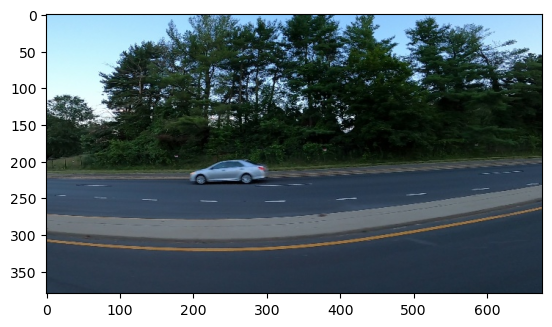

In [7]:
image = random.choice(index)
img = cv2.imread(f'training_images/{image}', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
data=df[["image_id","x","y","w","h","classes"]]

In [9]:
data

image_id         x         y         w         h  classes
0     vid_4_1000.jpg  0.450434  0.539817  0.068741  0.095238        0
1    vid_4_10000.jpg  0.100217  0.557191  0.155572  0.129987        0
2    vid_4_10040.jpg  0.444645  0.543678  0.181621  0.157014        0
3    vid_4_10020.jpg  0.833213  0.531451  0.197540  0.155727        0
4    vid_4_10060.jpg  0.110347  0.559122  0.171491  0.136422        0
..               ...       ...       ...       ...       ...      ...
554   vid_4_9860.jpg  0.036417  0.571770  0.072833  0.099741        0
555   vid_4_9880.jpg  0.640932  0.535500  0.305899  0.247409        0
556   vid_4_9900.jpg  0.104880  0.536148  0.209760  0.186528        0
557   vid_4_9960.jpg  0.816824  0.527728  0.191551  0.148964        0
558   vid_4_9980.jpg  0.421704  0.553635  0.187910  0.146373        0

[559 rows x 6 columns]

In [10]:
files = list(df.image_id.unique())

files_train, files_valid = train_test_split(files, test_size = 0.2)

In [11]:
IMAGES = "images/"
LABELS = "labels/"

In [12]:
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [13]:
TRAIN = "training_images"
TEST = "testing_images"

In [14]:
train_filename = set(files_train)
valid_filename = set(files_valid)
for file in glob.glob(TRAIN+"/*"):
    fname =os.path.basename(file)
    if fname in train_filename:
        shutil.copy(file, IMAGES+"train")
    elif fname in valid_filename:
        shutil.copy(file, IMAGES+"valid")

In [15]:
for _, row in df.iterrows():    
    image_file = row['image_id']
    if image_file in train_filename:   
        annotation_file = os.path.join(LABELS) + "train/" + image_file.replace('.jpg', '.txt')
    else:
        annotation_file = os.path.join(LABELS) + "valid/" + image_file.replace('.jpg', '.txt')
        
    with open(annotation_file, 'a') as ann_file:
        ann_file.write(f" {row['classes']} {row['x']} {row['y']} {row['w']} {row['h']}\n")

In [16]:
%%writefile dataset.yaml
# Path
train: C:\Users\LENOVO\Desktop\ML\car detection\images\train
val: C:\Users\LENOVO\Desktop\ML\car detection\images\valid

# Classes
nc: 1
names: ['car']

Overwriting dataset.yaml


In [17]:
model = YOLO('yolov8n.pt')

In [18]:
model.train(data="dataset.yaml", epochs=30, batch=16,lr0=0.00001)

New https://pypi.org/project/ultralytics/8.0.143 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.137  Python-3.9.13 torch-2.0.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, reti


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30         0G       1.24     0.9115      1.086         31        640: 100%|██████████| 18/18 [01:27<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<0
                   all         71        110      0.969      0.936      0.984      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30         0G      1.211     0.8825       1.07         34        640: 100%|██████████| 18/18 [01:26<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<0
                   all         71        110      0.962      0.925      0.958      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30         0G      1.229     0.8501      1.076         29        640: 100%|██████████| 18/18 [01

      28/30         0G      1.006     0.5751     0.9987         14        640: 100%|██████████| 18/18 [01:27<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<0
                   all         71        110      0.965          1      0.993      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30         0G     0.9823     0.5523     0.9932         13        640: 100%|██████████| 18/18 [01:28<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<0
                   all         71        110      0.956      0.998      0.991      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30         0G     0.9884     0.5507     0.9973         15        640: 100%|██████████| 18/18 [01:26<00:00,  4.
                 Class     Images  Instances      Box(P         

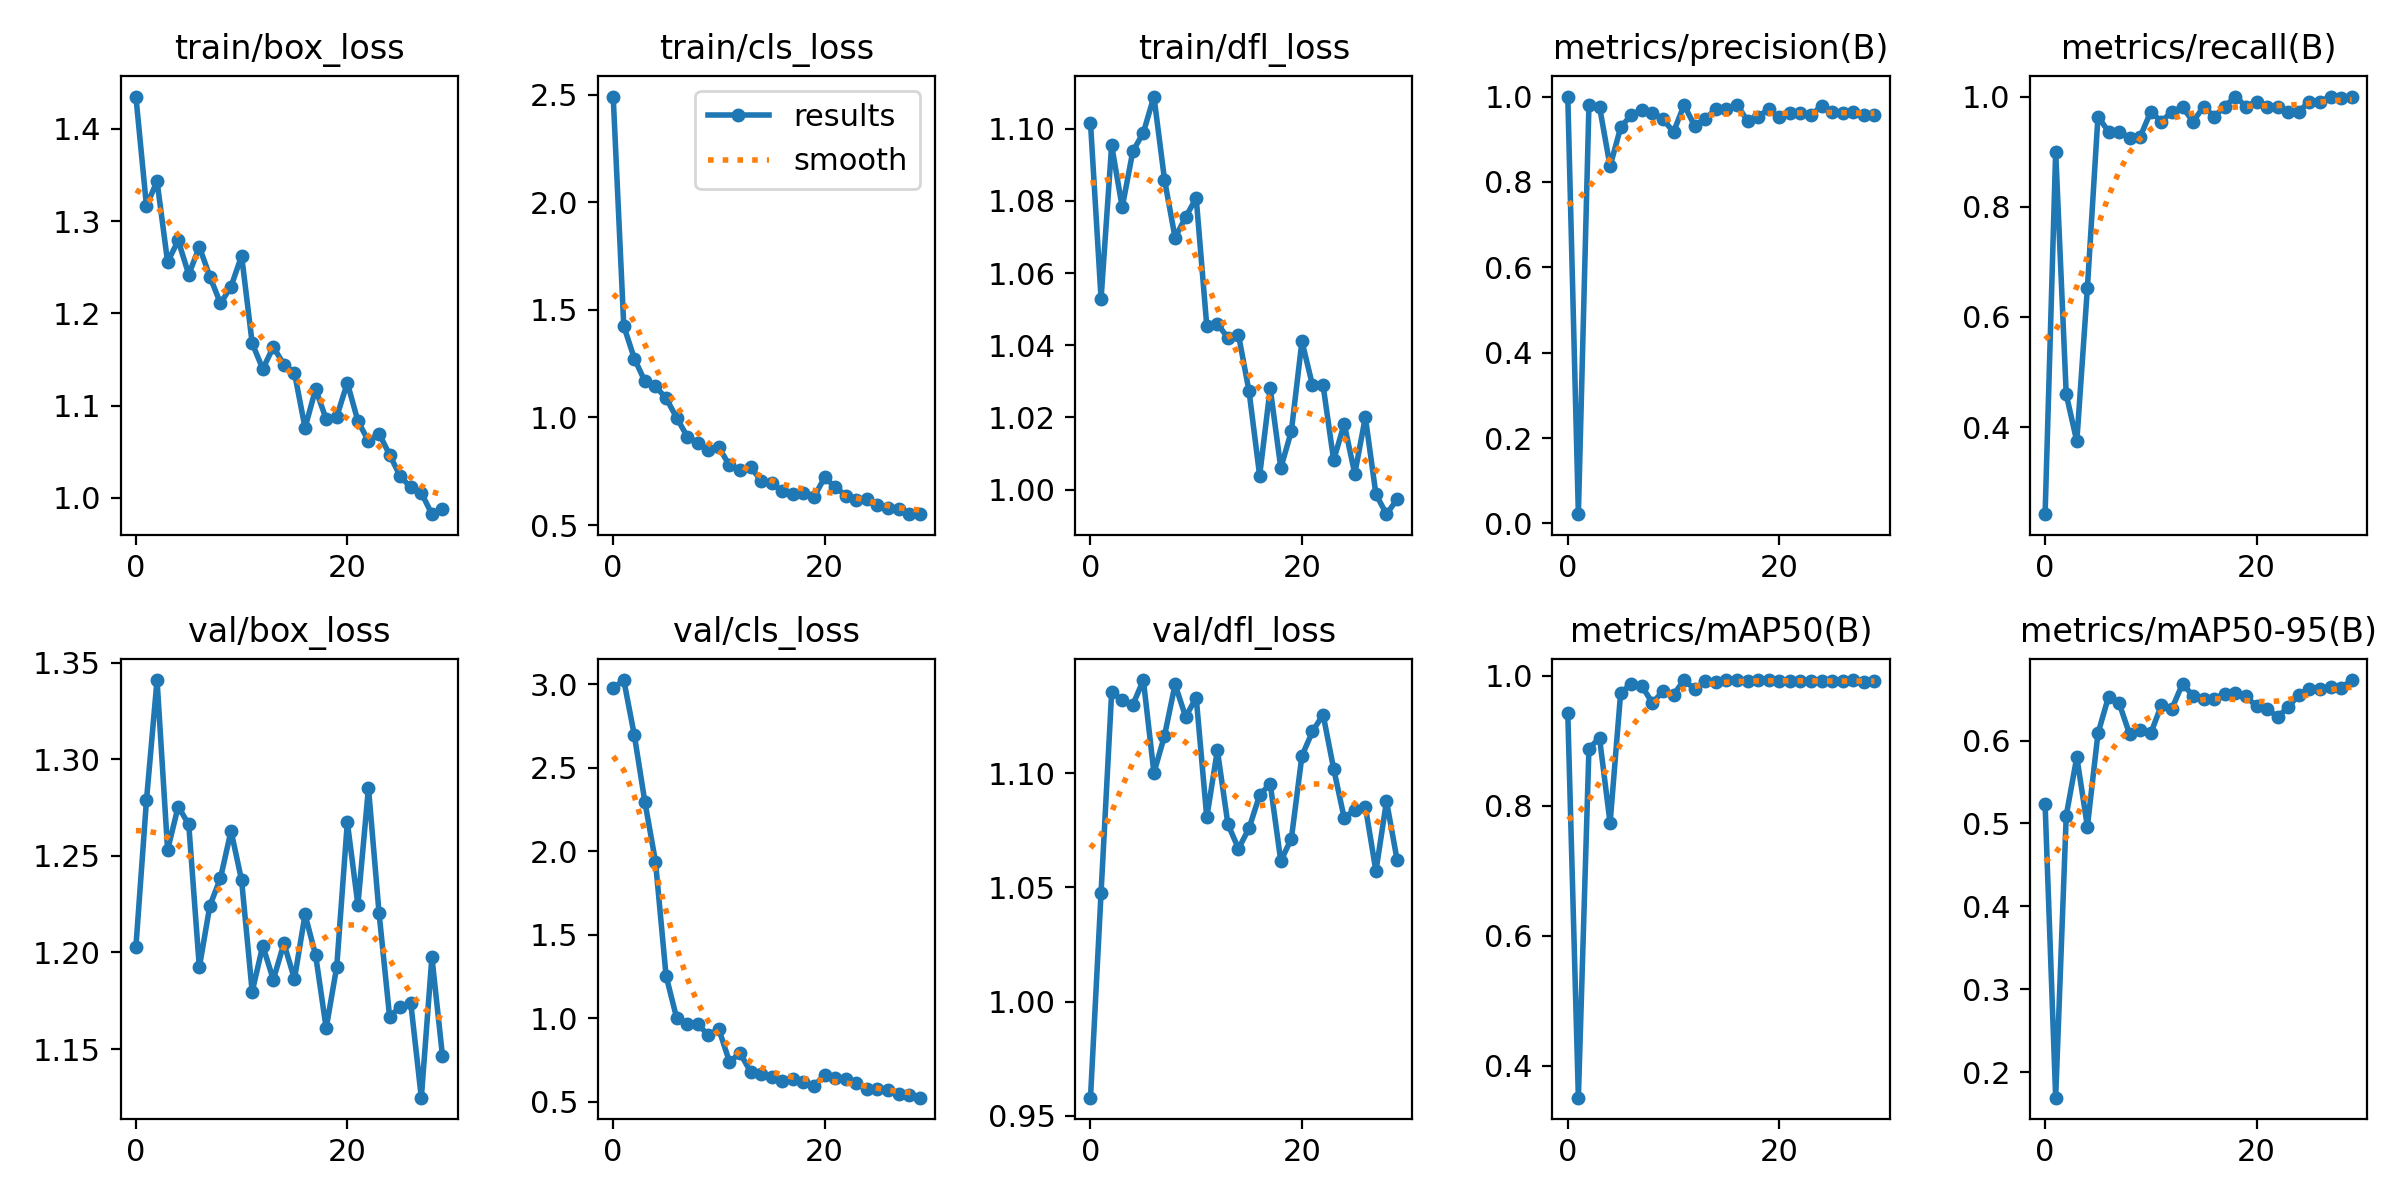

In [20]:
Image.open("runs/detect/train/results.png")

In [21]:
model = YOLO('runs/detect/train/weights/last.pt')
ret = model("testing_images",save=True, conf=0.2, iou=0.5)


image 1/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25100.jpg: 384x640 (no detections), 68.0ms
image 2/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25120.jpg: 384x640 (no detections), 62.0ms
image 3/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25140.jpg: 384x640 (no detections), 60.1ms
image 4/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25160.jpg: 384x640 (no detections), 61.0ms
image 5/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25180.jpg: 384x640 (no detections), 59.0ms
image 6/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25200.jpg: 384x640 (no detections), 56.7ms
image 7/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25220.jpg: 384x640 (no detections), 63.0ms
image 8/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_25240.jpg: 384x640 (no detections), 62.1ms
image 9/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_im

image 75/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28060.jpg: 384x640 (no detections), 60.0ms
image 76/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28080.jpg: 384x640 (no detections), 63.0ms
image 77/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28180.jpg: 384x640 (no detections), 61.0ms
image 78/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28260.jpg: 384x640 1 car, 61.0ms
image 79/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28320.jpg: 384x640 (no detections), 62.0ms
image 80/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28340.jpg: 384x640 (no detections), 60.0ms
image 81/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28360.jpg: 384x640 (no detections), 57.0ms
image 82/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_28380.jpg: 384x640 1 car, 61.0ms
image 83/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_2

image 147/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31060.jpg: 384x640 2 cars, 61.0ms
image 148/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31080.jpg: 384x640 2 cars, 63.0ms
image 149/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31100.jpg: 384x640 1 car, 59.0ms
image 150/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31120.jpg: 384x640 2 cars, 61.0ms
image 151/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31140.jpg: 384x640 1 car, 58.9ms
image 152/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31160.jpg: 384x640 1 car, 60.9ms
image 153/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31180.jpg: 384x640 (no detections), 55.0ms
image 154/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31200.jpg: 384x640 1 car, 59.0ms
image 155/175 C:\Users\LENOVO\Desktop\ML\car detection\testing_images\vid_5_31260.jpg: 384x640 (no detections), 58.

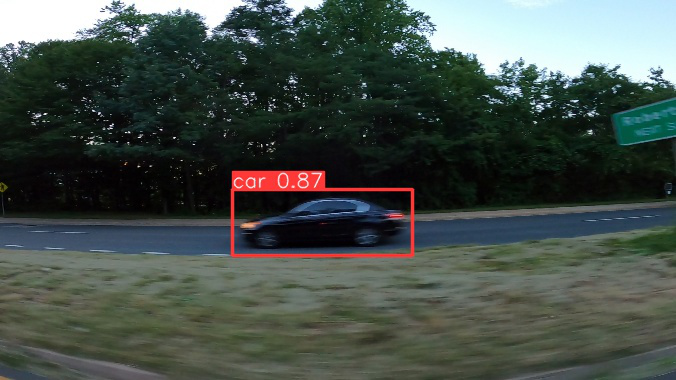

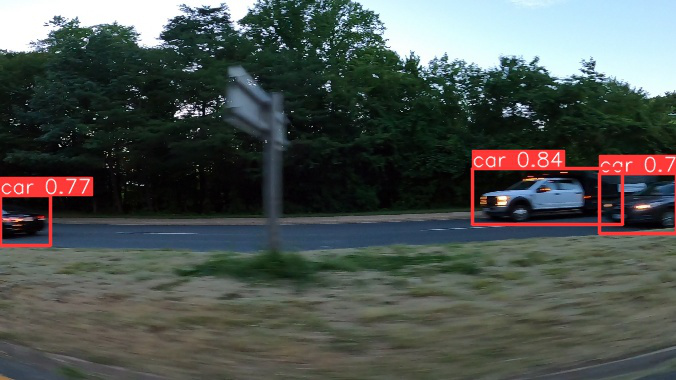

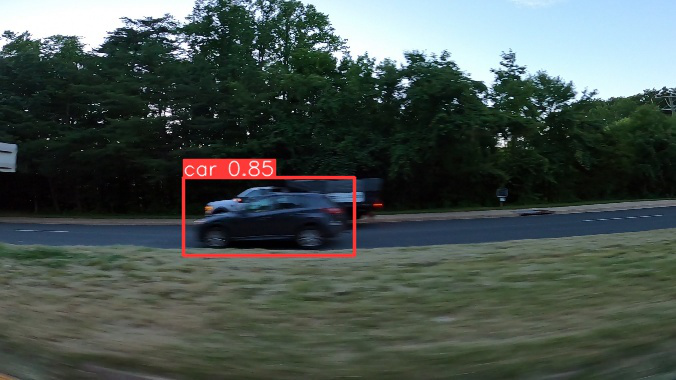

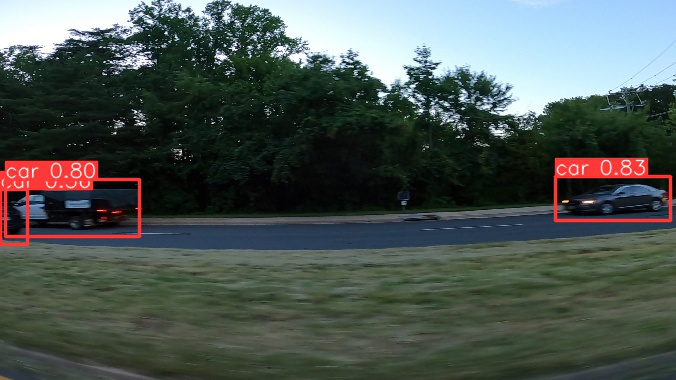

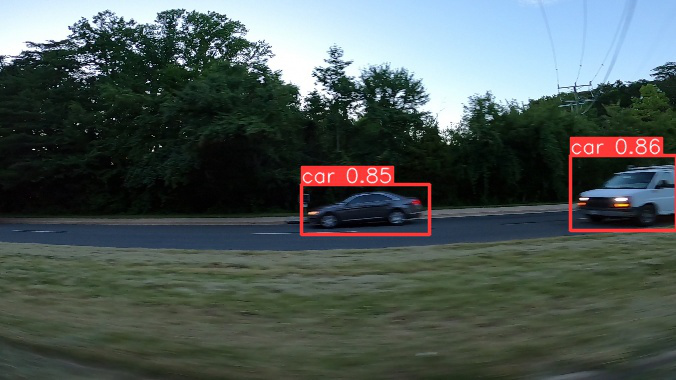

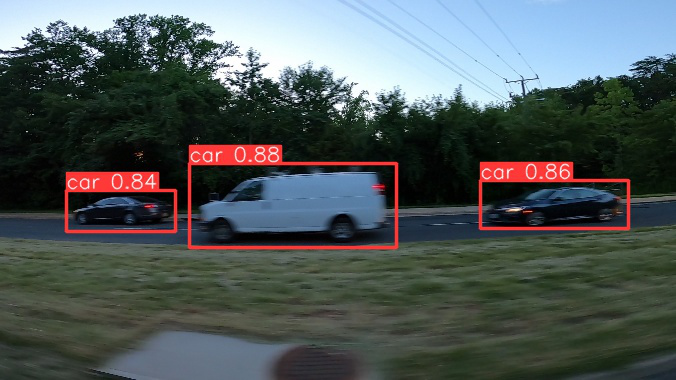

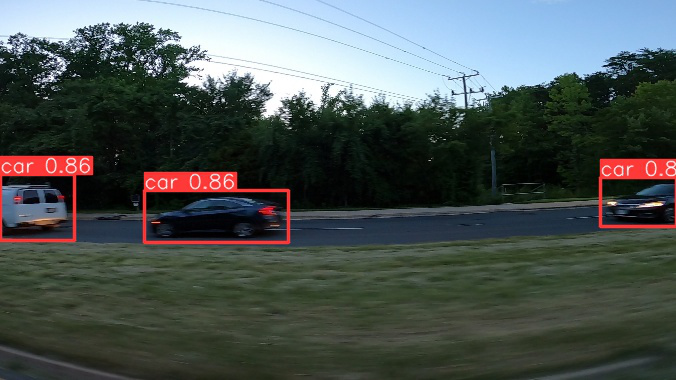

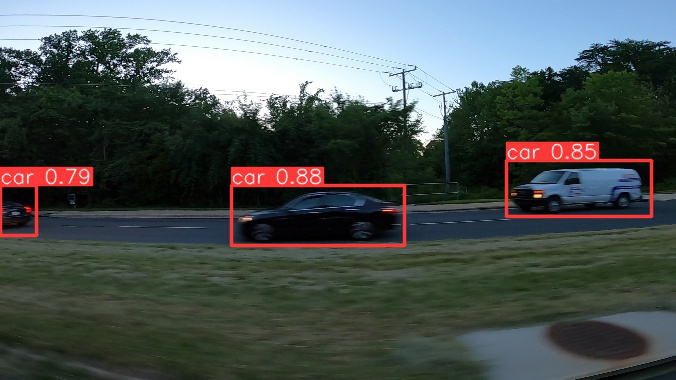

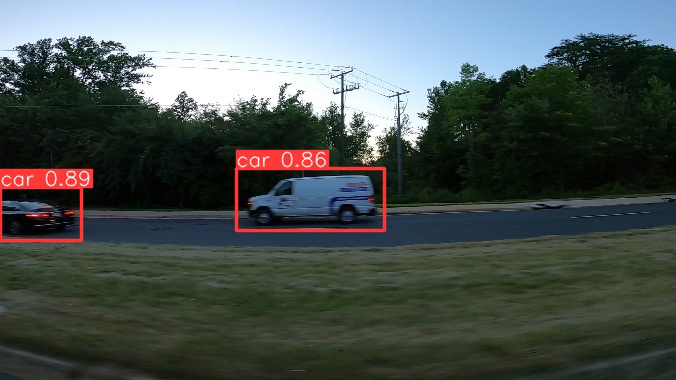

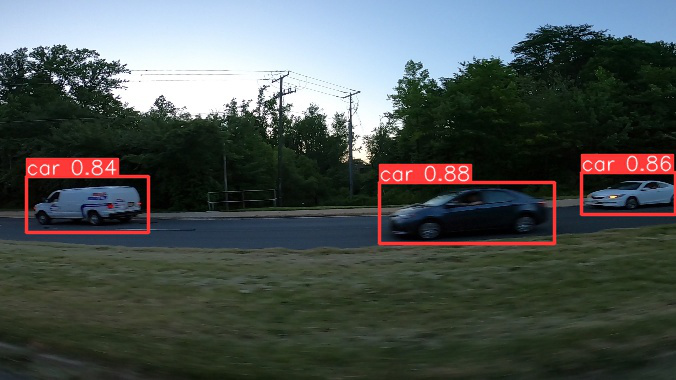

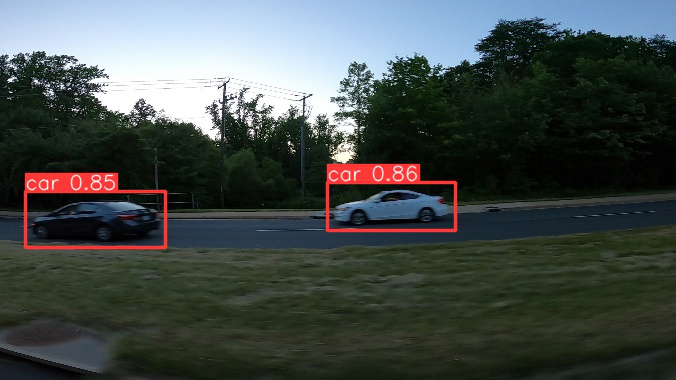

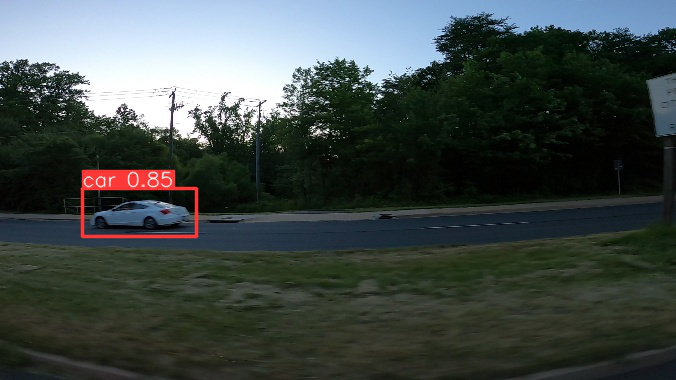

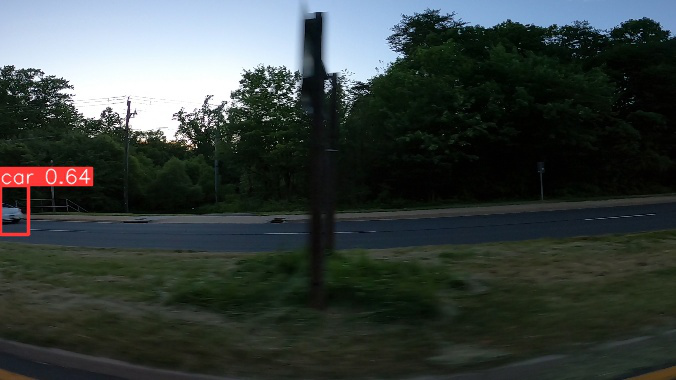

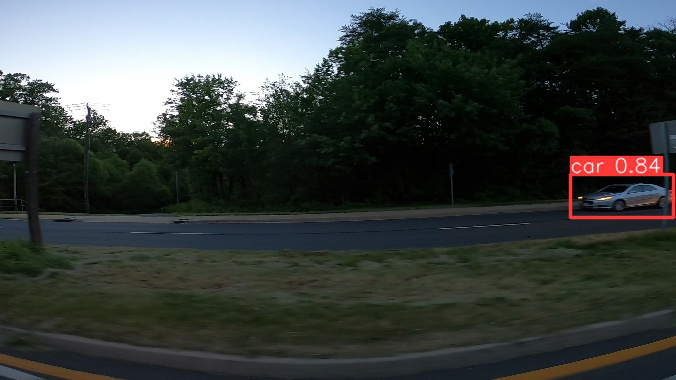

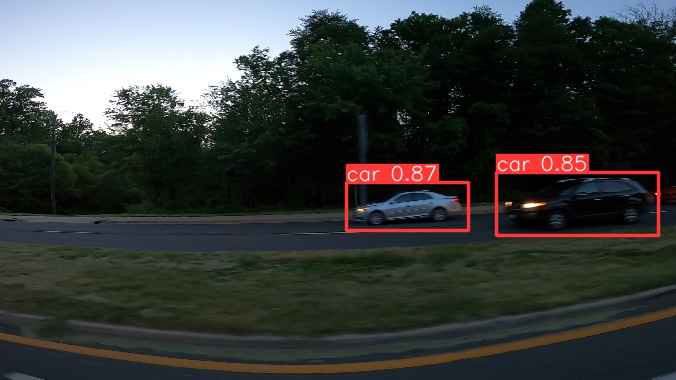

In [25]:
files = glob.glob("./runs/detect/predict/*")
for i in range(15, 30, 1):
    img = Image.open(files[i])
    display(img)